<a href="https://colab.research.google.com/github/dadatadh/ML_Model_analysis/blob/main/7_%EC%8B%A0%EC%9A%A9%EC%B9%B4%EB%93%9C_%EC%B1%84%EB%AC%B4_%EB%B6%88%EC%9D%B4%ED%96%89_%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ML 07**  
**┗ 신용카드 채무 불이행 고객 예측**
---
> **목차(Context)**

* 문제상황 및 데이터 살펴보기
* 문제해결 프로세스 정의
* 🥉Session 1 - 「신용카드 사용패턴 탐색」
* 🥈Session 2 - 「이용한도 수준에 따른 채무 불이행 분석」
* 🥇Session 3 - 「ML 활용 채무 불이행 고객 예측」

In [1]:
# ▶ Warnings 제거
import warnings
warnings.filterwarnings('ignore')

# ▶ Google drive mount or 폴더 클릭 후 구글드라이브 연결
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
# ▶ 경로 설정 (※ Colab을 활성화시켰다면 보통 Colab Notebooks 폴더가 자동 생성)
import os
os.chdir('/content/drive/MyDrive/데이터분석/파이썬_실습/ML 실습/ML실습/ML실습/7_신용카드 채무 불이행 고객 예측')
os.getcwd()

'/content/drive/MyDrive/데이터분석/파이썬_실습/ML 실습/ML실습/ML실습/7_신용카드 채무 불이행 고객 예측'

## **문제상황 및 데이터 살펴보기**
---
> **시나리오** 💳❗ (서비스 운영자, Risk management)

```
카드사 A는 최근 점점 늘어가는 채무 불이행 고객 때문에 골치를 썩고 있다. 네이버페이, 카카오페이 등 간편결제 회사와 같은 경쟁사들이 등장하고  
있는 어려운 상황에서 채무 불이행 고객으로 인한 손실이 늘어나고 있는 상황이다. 이에 신용카드 채무 불이행이 예상되는 고객들을 블랙리스트로  
관리하고, 한도를 줄여서 최대한의 손실을 막아보고자 한다.

```  

> **데이터 살펴보기**

* 고객 ID별 카드 Spending data
* 데이터 명세 ⬇

|ID|LIMIT_BAL|SEX|EDUCATION|MARRIAGE|AGE|
|:---:|:---:|:---:|:---:|:---:|:---:|
|고객 아이디|신용한도|성별(1-남성, 2-여성)|교육수준(1-대학원, 2-대학교, 3-고등학교, 4-기타, 5-모름, 6-모름)|결혼(1-기혼, 2-독신, 3-기타)|나이||
|PAY_0|PAY_2|PAY_3|PAY_4|PAY_5|PAY_6|
|05년9월 상환상태(-2-무소비, -1-정액 결제, 0-리볼빙크레딧, 1-한달 지연, ..., 9-9개월 지불지연)|05년8월 상환상태|05년7월 상환상태|05년6월 상환상태|05년5월 상환상태|05년4월 상환상태|
|BILL_AMT1|BILL_AMT2|BILL_AMT3|BILL_AMT4|BILL_AMT5|BILL_AMT6|
|05년9월 청구서 금액|05년8월 청구서 금액|05년7월 청구서 금액|05년6월 청구서 금액|05년5월 청구서 금액|05년4월 청구서 금액|
|PAY_AMT1|PAY_AMT2|PAY_AMT3|PAY_AMT4|PAY_AMT5|PAY_AMT6|
|05년9월 지불금액|05년8월 지불금액|05년7월 지불금액|05년6월 지불금액|05년5월 지불금액|05년4월 지불금액|
|default payment next month|
|채무 불이행 여부|

In [4]:
# ▶ Data read
import pandas as pd
df = pd.read_excel('7_credit_card_pay.xlsx')
print(df.shape)
print(df['default payment next month'].value_counts())
df.head(5)

#채무불이행여부 1: 불이행

(30000, 25)
0    23364
1     6636
Name: default payment next month, dtype: int64


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0



## **문제해결 프로세스 정의**
---
> **문제정의**

```
▶ 신용카드 대금 채무 불이행으로 인한 손실
```  

> **기대효과**

```
▶ 채무 불이행으로 인한 손실 감소
```

> **해결방안**

```
▶ 채무 불이행 고객 예측 및 블랙리스트 관리(신용한도 조정)
▶ Session 1 🥉
 - 고객 프로필 정보 확인 및 파생변수 생성 및 검증
▶ Session 2 🥈
 - 고객 프로필 정보, 이용한도에 따른 채무 불이행률 탐색
▶ Session 3 🥇
 - ML알고리즘 활용 채무 불이행 고객 예측
```

> **성과측정**  

```
▶ 블랙리스트 관리 후 채무 불이행 손실 감소률(%)
```

> **현업적용**  

```
▶ 매 월 Model에 Input하기 위한 Data mart 생성
▶ Data mart 예측 Model에 Input후 채무불이행 예측 고객군 추출
▶ 추출한 고객 대상으로 신용한도 조정 및 블랙리스트 관리를 통한 손실 방어
```

> **주요 코드 미리 살펴보기**  

```
▶ session 1 → np.where(), sns.catplot(), replace()
▶ session 2 → value_counts(), pd.pivot_table(), reset_index(), sort_values()
▶ session 3 → RandomForestClassifier, roc_auc_score()
```

## **🥉Session 1**  
**┗ 신용카드 사용패턴 탐색**  
---

### · Data 전처리  
---
* 수집된 데이터의 기본 정보들을 확인  

  (1) Data shape(형태) 확인

  (2) Data type 확인

  (3) Null값 확인 (※ 빈 값의 Data)

  (4) Outlier 확인 (※ 정상적인 범주를 벗어난 Data)  


In [ ]:
# ▶ Data 형태 확인
print('df', df.shape)

df (30000, 25)


In [ ]:
# ▶ Data type 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   ID                          30000 non-null  int64
 1   LIMIT_BAL                   30000 non-null  int64
 2   SEX                         30000 non-null  int64
 3   EDUCATION                   30000 non-null  int64
 4   MARRIAGE                    30000 non-null  int64
 5   AGE                         30000 non-null  int64
 6   PAY_0                       30000 non-null  int64
 7   PAY_2                       30000 non-null  int64
 8   PAY_3                       30000 non-null  int64
 9   PAY_4                       30000 non-null  int64
 10  PAY_5                       30000 non-null  int64
 11  PAY_6                       30000 non-null  int64
 12  BILL_AMT1                   30000 non-null  int64
 13  BILL_AMT2                   30000 non-null  int64
 14  BILL_A

In [ ]:
# ▶ Null 값 확인
print(df.isnull().sum())

ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default payment next month    0
dtype: int64


In [ ]:
# ▶ Outlier 확인, 음수값 확인
df.describe()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


In [ ]:
print('채무 불이행률', str(df[df['default payment next month'] == 1]['default payment next month'].count()/df['default payment next month'].count()*100)+'%',)
print('')
df['default payment next month'].value_counts()

채무 불이행률 22.12%



0    23364
1     6636
Name: default payment next month, dtype: int64

### · 고객 프로필 정보 확인
---

In [ ]:
# ▶ 고객 프로필 정보 col
df.columns[1:6]

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE'], dtype='object')

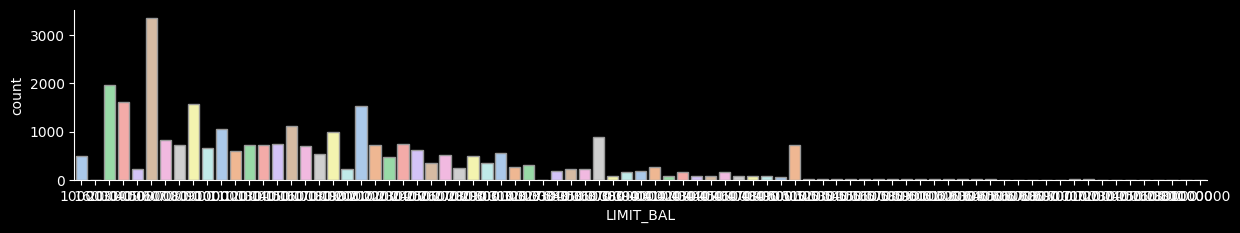

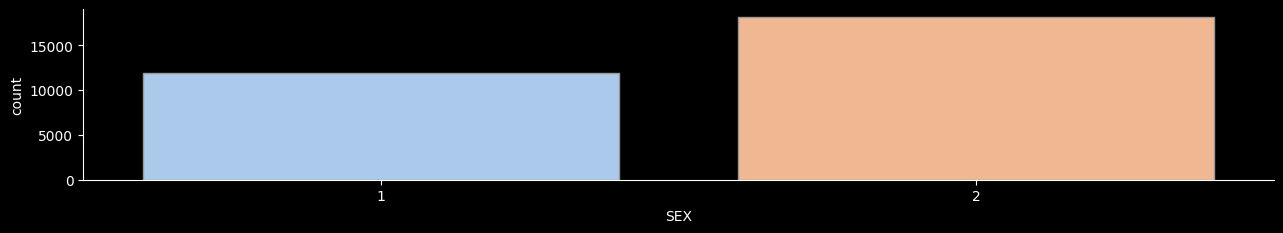

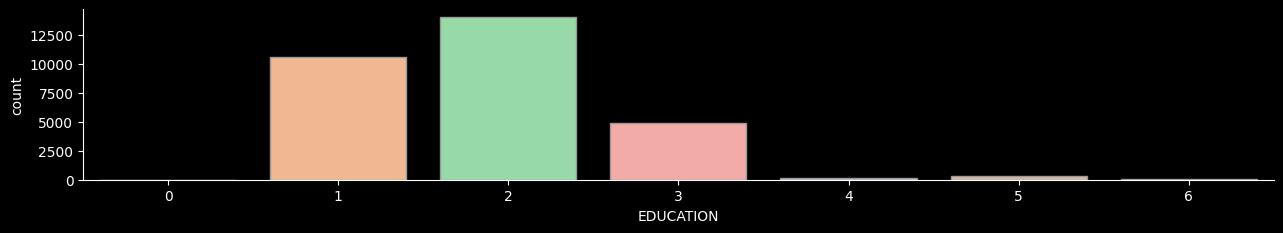

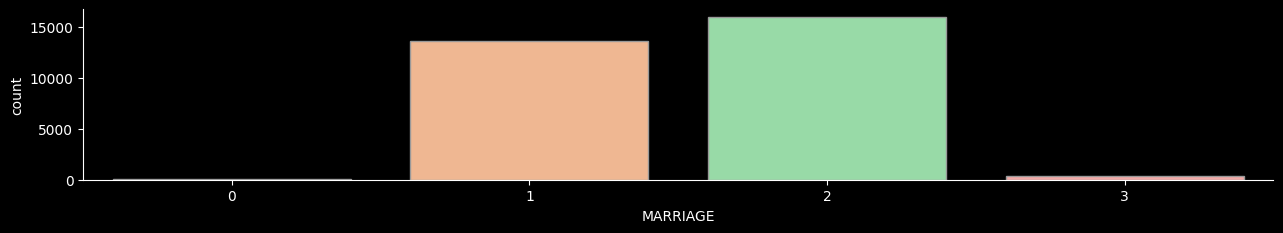

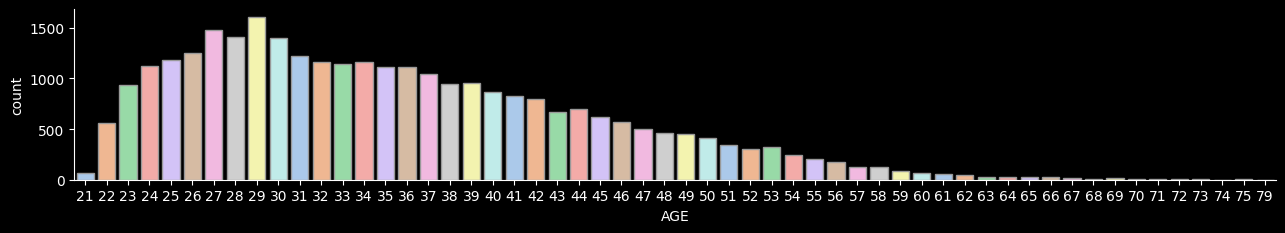

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use(['dark_background'])

columns = ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE']

for name in columns:
    sns.catplot(data = df, x = name, kind = 'count', palette = 'pastel', edgecolor = '.6')
    plt.gcf().set_size_inches(15,2)

In [ ]:
#최소값 최대값 기준으로 LIMIT_BAL 4등분
import numpy as np
df_copy = df.copy()

bins = np.linspace(df_copy['LIMIT_BAL'].min(), df_copy['LIMIT_BAL'].max(), num = 5)
labels = [f"{int((bins[i] + bins[i+1])/2)}" for i in range(len(bins)-1)]
df_copy['LIMIT_BAL'] = pd.cut(df_copy['LIMIT_BAL'], bins=bins, labels=labels, include_lowest = True)
df_copy['LIMIT_BAL'].value_counts()

133750    23283
381250     6511
628750      200
876250        6
Name: LIMIT_BAL, dtype: int64

In [ ]:
bins = [20,30,40,50,60,float('inf')]
labels = [20,30,40,50,60]
df_copy['AGE'] = pd.cut(df_copy['AGE'], bins = bins, labels = labels)
df_copy['AGE'].value_counts()

20    11013
30    10713
40     6005
50     1997
60      272
Name: AGE, dtype: int64

In [ ]:
#LIMIT_BAL 데이터 4등분 코드 참고

# df_copy = df.copy()

# bins = pd.qcut(df_copy['LIMIT_BAL'], q =4)
# labels = [f"{(interval.left + interval.right)/2:.0f}" for interval in bins.cat.categories]

# df_copy['LIMIT_BAL'] = bins.cat.codes.apply(lambda x: labels[x])
# df_copy['LIMIT_BAL'].value_counts()

30000     7676
190000    7643
95000     7614
620000    7067
Name: LIMIT_BAL, dtype: int64

In [ ]:
# ▶ 교육 수준 0, 4, 5, 6은 데이터가 너무 적으므로 하나의 카테고리로 통합
import numpy as np
df_copy['EDUCATION'] = np.where((df_copy['EDUCATION']>=4) | (df_copy['EDUCATION']==0) , 4, df_copy['EDUCATION'])
df_copy['EDUCATION'].value_counts()

2    14030
1    10585
3     4917
4      468
Name: EDUCATION, dtype: int64

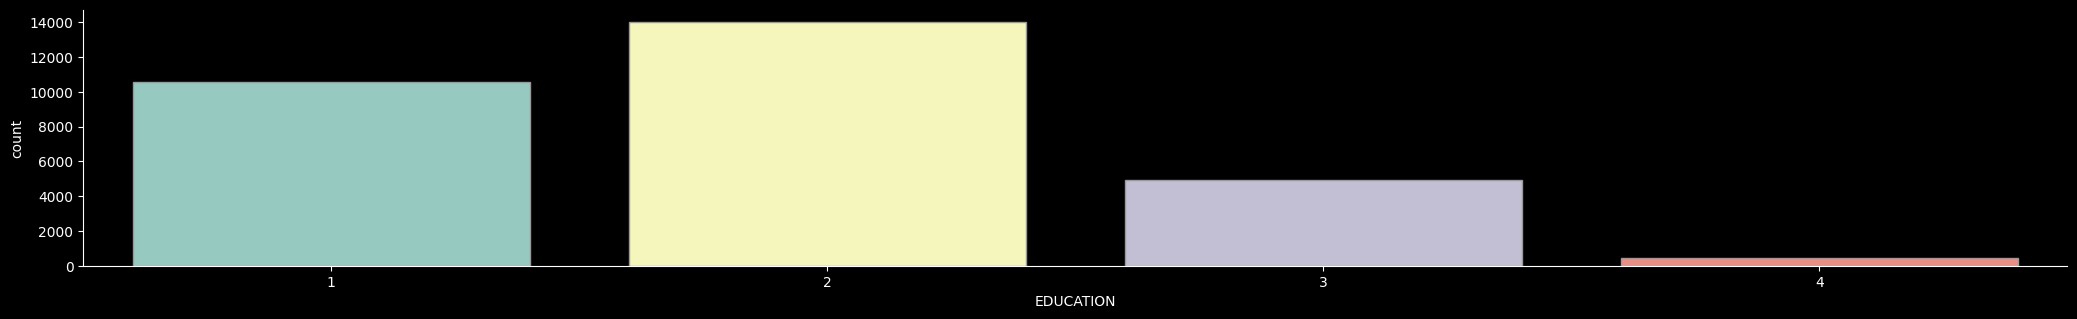

In [ ]:
# ▶ 교육수준(1-대학원 2-대학 3-고등학교 4-기타)
sns.catplot(x="EDUCATION", kind="count", edgecolor=".6",data=df_copy);
plt.gcf().set_size_inches(25, 3)

### · 청구금액 대비 지불 수준 확인
---

In [ ]:
# ▶ 청구 수준 대비 지불 수준 확인
# ▶ 청구 대비 지불한 금액이 낮다면 연체 확률이 높을 것이고, 청구 대비 지불이 높다면, 과거 연체비용까지 지불했을 가능성이 클 것이라는 가설 수립
df_copy[['ID', 'BILL_AMT1', 'PAY_AMT1', 'BILL_AMT2', 'PAY_AMT2', 'BILL_AMT3', 'PAY_AMT3', 'BILL_AMT4', 'PAY_AMT4', 'BILL_AMT5', 'PAY_AMT5', 'BILL_AMT6', 'PAY_AMT6']]

,ID,BILL_AMT1,PAY_AMT1,BILL_AMT2,PAY_AMT2,BILL_AMT3,PAY_AMT3,BILL_AMT4,PAY_AMT4,BILL_AMT5,PAY_AMT5,BILL_AMT6,PAY_AMT6
0,1,3913,0,3102,689,689,0,0,0,0,0,0,0
1,2,2682,0,1725,1000,2682,1000,3272,1000,3455,0,3261,2000
2,3,29239,1518,14027,1500,13559,1000,14331,1000,14948,1000,15549,5000
3,4,46990,2000,48233,2019,49291,1200,28314,1100,28959,1069,29547,1000
4,5,8617,2000,5670,36681,35835,10000,20940,9000,19146,689,19131,679
...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,188948,8500,192815,20000,208365,5003,88004,3047,31237,5000,15980,1000
29996,29997,1683,1837,1828,3526,3502,8998,8979,129,5190,0,0,0
29997,29998,3565,0,3356,0,2758,22000,20878,4200,20582,2000,19357,3100
29998,29999,-1645,85900,78379,3409,76304,1178,52774,1926,11855,52964,48944,1804


In [ ]:
# ▶ 과거 6개월 동안 총 청구 대비 지불 수준을 확인하기 위해 새로운 col 생성
df_copy['PAY/BILL'] = round((df_copy['PAY_AMT1'] + df_copy['PAY_AMT2'] + df_copy['PAY_AMT3'] + df_copy['PAY_AMT4'] + df_copy['PAY_AMT5'] + df_copy['PAY_AMT6'])
                                / (df_copy['BILL_AMT1'] + df_copy['BILL_AMT2'] + df_copy['BILL_AMT3'] + df_copy['BILL_AMT4'] + df_copy['BILL_AMT5'] + df_copy['BILL_AMT6']) * 100,1)
df_copy['PAY/BILL']

0         8.9
1        29.3
2        10.8
3         3.6
4        54.0
         ... 
29995     5.9
29996    68.4
29997    44.4
29998    55.2
29999     3.6
Name: PAY/BILL, Length: 30000, dtype: float64

In [ ]:
# ▶ 총 청구 대금이 0인 고객이 존재할 경우, inf (무한대) 로 표현되기 때문에 전처리를 통해 제거 (0으로)
 # 아래 코드는 null 로 바꾸고 이후에 0으로 교체함
  #사실 바로 0으로 바꿔도 됨
#NA인 경우에는 0으로 채움

df_copy['PAY/BILL'] = df_copy['PAY/BILL'].replace([np.inf, -np.inf], np.nan)
df_copy['PAY/BILL'] = df_copy['PAY/BILL'].fillna(0)

In [ ]:
# ▶ 이상 Data 처리
df_copy['PAY/BILL'] = np.where(df_copy['PAY/BILL']>100, 100, df_copy['PAY/BILL'])
df_copy['PAY/BILL'] = np.where(df_copy['PAY/BILL']<0, 0, df_copy['PAY/BILL'])

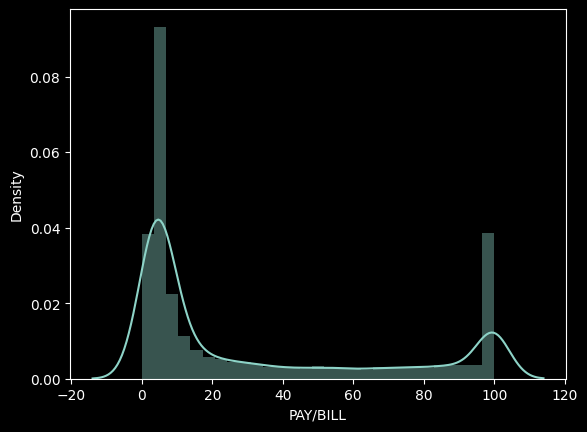

In [ ]:
# ▶ 대부분의 고객이 총 청구금액 대비 20% 수준에서만 지불을 하고 있음
sns.distplot(df_copy['PAY/BILL']);

## **🥈Session 2**  
**┗ 이용한도 수준에 따른 채무 불이행 분석**  
---

### · 고객 프로필 - 채무 불이행 분석
---

In [ ]:
df_profile=pd.DataFrame(df_copy.groupby(df_copy['SEX'])['default payment next month'].value_counts())
df_profile.columns = ['cnt']
df_profile = df_profile.reset_index()
df_profile

,SEX,default payment next month,cnt
0,1,0,9015
1,1,1,2873
2,2,0,14349
3,2,1,3763


In [ ]:
# ▶ 2단계(Pivot table)
df_profile = pd.pivot_table(df_profile,                          # 피벗할 데이터프레임
                      index = 'SEX',                             # 행 위치에 들어갈 열
                      columns = 'default payment next month',    # 열 위치에 들어갈 열
                      values = 'cnt')                            # 데이터로 사용할 열
df_profile

default payment next month,0,1
SEX,,
1,9015,2873
2,14349,3763


In [ ]:
# ▶ 3단계
df_profile = df_profile.reset_index()
df_profile.columns.names=['']       #이렇게 없엘 수 있음
df_profile

,SEX,0,1
0,1,9015,2873
1,2,14349,3763


In [ ]:
 # ▶ 4단계
 # sex == 1, 남성의 채무 불이행률이 더 높음
df_profile['ratio'] = round(df_profile.iloc[:,2] / (df_profile.iloc[:,1]+df_profile.iloc[:,2])*100,1)
df_profile=df_profile.sort_values(by=['ratio'], ascending=False)
df_profile

,SEX,0,1,ratio
0,1,9015,2873,24.2
1,2,14349,3763,20.8


In [ ]:
columns = ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE']


for name in columns:
    df_profile = pd.DataFrame(df_copy.groupby(name)['default payment next month'].value_counts())
    df_profile.columns = ['cnt']
    df_profile = df_profile.reset_index()

    df_profile = pd.pivot_table(df_profile,
                                index = name,
                                columns = ['default payment next month'],
                                values = 'cnt')
    df_profile = df_profile.reset_index()
    df_profile.columns.names=['']

    df_profile['sign_ratio'] = round((df_profile.iloc[:,2]/(df_profile.iloc[:,1]+df_profile.iloc[:,2]))*100,2)
    df_profile = df_profile.sort_values(by=['sign_ratio'], ascending = False)
    print(df_profile)
    print('')

  LIMIT_BAL        0       1  sign_ratio
0    133750  17584.0  5699.0       24.48
1    381250   5597.0   914.0       14.04
2    628750    177.0    23.0       11.50
3    876250      6.0     NaN         NaN

   SEX      0     1  sign_ratio
0    1   9015  2873       24.17
1    2  14349  3763       20.78

   EDUCATION      0     1  sign_ratio
2          3   3680  1237       25.16
1          2  10700  3330       23.73
0          1   8549  2036       19.23
3          4    435    33        7.05

   MARRIAGE      0     1  sign_ratio
3         3    239    84       26.01
1         1  10453  3206       23.47
2         2  12623  3341       20.93
0         0     49     5        9.26

  AGE     0     1  sign_ratio
4  60   199    73       26.84
3  50  1493   504       25.24
2  40  4606  1399       23.30
0  20  8542  2471       22.44
1  30  8524  2189       20.43



### · 이용한도 - 채무 불이행 분석

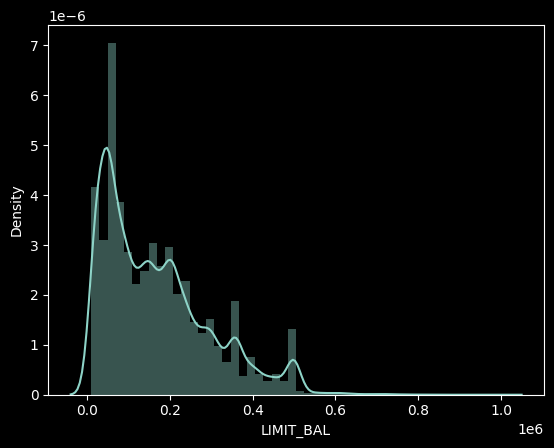

In [ ]:
# ▶ distplot을 통해 데이터 분포 확인
 #LIMIT_BAL, 이용한도 데이터 분석
sns.distplot(df['LIMIT_BAL']);

#신용한도가 낮은 고객들이 많은 것을 알 수 있음

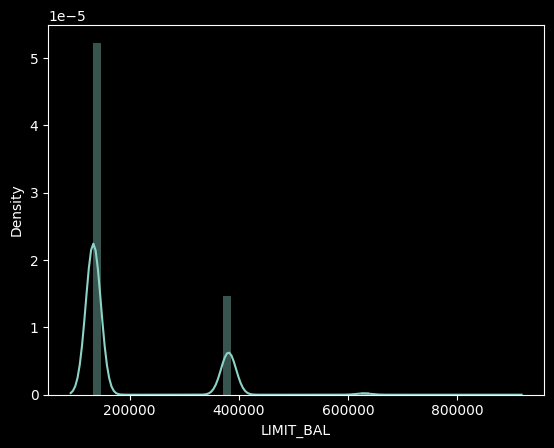

In [ ]:
#구간화 진행한 데이터를 활용
 #LIMIT_BAL가 낮을수록 채무불이행이 매우 높음
sns.distplot(df_copy['LIMIT_BAL']);

In [ ]:
# ▶ Numeric(연속형) 변수의 구간화 작업
# ▶ 100,000 이하, 100,000 초과 300,000 이하, 300,000 초과 500,000 이하, 500,000 초과(4 Group)
 #임의로 설정한 것


# df['LIMIT_GP'] = np.where (df['LIMIT_BAL'] <= 100000, 1,
#                            np.where(df['LIMIT_BAL'] <= 300000, 2,
#                            np.where(df['LIMIT_BAL'] <= 500000, 3, 4)))

#print(df['LIMIT_GP'].value_counts())
# df[['ID', 'LIMIT_BAL', 'LIMIT_GP']]


,ID,LIMIT_BAL,LIMIT_GP
0,1,20000,1
1,2,120000,2
2,3,90000,1
3,4,50000,1
4,5,50000,1
...,...,...,...
29995,29996,220000,2
29996,29997,150000,2
29997,29998,30000,1
29998,29999,80000,1


In [ ]:
# # ▶ 신용한도 > 100,000 이하(1 Group), 100,000 초과 300,000 이하(2 Group), 300,000 초과 500,000 이하(3 Group), 500,000 초과(4 Group)
# # ▶ 1단계
#  #구간화된 LIMIT_GP를 기준으로 groupby 진행
# df_profile=pd.DataFrame(df['default payment next month'].groupby(df['LIMIT_GP']).value_counts())
# df_profile.columns=['cnt']
# df_profile=df_profile.reset_index()

# # ▶ 2단계
# df_profile = pd.pivot_table(df_profile,
#                     index = 'LIMIT_GP',
#                     columns = 'default payment next month',
#                     values = 'cnt')

# # ▶ 3단계
# df_profile = df_profile.reset_index()
# df_profile.columns.names=['']


# # ▶ 4단계
# df_profile['sign_ratio'] =   round((df_profile.iloc[:,2] / (df_profile.iloc[:,1] + df_profile.iloc[:,2])) * 100,1)
# df_profile=df_profile.sort_values(by=['sign_ratio'], ascending=False)
# df_profile

# #LIMIT_GP 별로 sign_ratio가 차이가 나는 것으로 보아, 채무불이행을 기준으로 분석을 진행하면 좋을 것으로 예상됨

,LIMIT_GP,0,1,sign_ratio
0,1,8814,3684,29.5
1,2,10592,2347,18.1
2,3,3775,582,13.4
3,4,183,23,11.2


## **🥇Session 3**  
**┗ ML 활용 채무 불이행 고객 예측**  
---

### · 모델링을 위한 데이터 준비
---
* 모델링을 수행하기 위해 Feature와 예측하고자하는 값인 Y로 데이터를 나눔
* 학습과 예측을 위한 Train / Test set 분할

In [ ]:
df_copy.head(5)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month,PAY/BILL
0,1,133750,2,2,1,20,2,2,-1,-1,...,0,0,0,689,0,0,0,0,1,8.9
1,2,133750,2,2,2,20,-1,2,0,0,...,3455,3261,0,1000,1000,1000,0,2000,1,29.3
2,3,133750,2,2,2,30,0,0,0,0,...,14948,15549,1518,1500,1000,1000,1000,5000,0,10.8
3,4,133750,2,2,1,30,0,0,0,0,...,28959,29547,2000,2019,1200,1100,1069,1000,0,3.6
4,5,133750,1,2,1,50,-1,0,-1,0,...,19146,19131,2000,36681,10000,9000,689,679,0,54.0


In [ ]:
df_copy.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month', 'PAY/BILL'],
      dtype='object')

In [ ]:
# ▶ 모델링을 학습하기 위한 Feature(X)와 Y데이터를 구분하는 단계
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

# ▶ 상위에서 생성한 그룹핑 변수들은 우선 제거 후 모델링 진행
 #채무불이행을 보기위해 Y에 default payment next month
X=df_copy.drop(['ID','default payment next month'], axis=1)
Y=df_copy['default payment next month']

#default payment next month 가 이진분류이기 때문에 stratify=Y를 통해 데이터 분포를 맞춰줌)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, stratify=Y)

print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)

(21000, 24)
(21000,)
(9000, 24)
(9000,)


### · 모델 학습 및 평가
---
* 모델을 학습하고 예측을 수행하여 성능을 평가

In [ ]:
x_train.isnull().sum()

LIMIT_BAL    0
SEX          0
EDUCATION    0
MARRIAGE     0
AGE          0
PAY_0        0
PAY_2        0
PAY_3        0
PAY_4        0
PAY_5        0
PAY_6        0
BILL_AMT1    0
BILL_AMT2    0
BILL_AMT3    0
BILL_AMT4    0
BILL_AMT5    0
BILL_AMT6    0
PAY_AMT1     0
PAY_AMT2     0
PAY_AMT3     0
PAY_AMT4     0
PAY_AMT5     0
PAY_AMT6     0
PAY/BILL     0
dtype: int64

In [ ]:
# ▶ 학습
 # 분류모델이기 때문에 classification_report를 통해 평가
from sklearn.metrics import classification_report
rfc = RandomForestClassifier(random_state=123456)
rfc.fit(x_train, y_train)

# ▶ 예측
y_pred_train = rfc.predict(x_train)
y_pred_test = rfc.predict(x_test)

print(classification_report(y_train, y_pred_train))
print(classification_report(y_test, y_pred_test))

#train_data에 과적합이 되어 있음을 알 수 있음
 #이러면 test 값에 대해서 예측력이 떨어짐

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     16355
           1       0.99      0.98      0.98      4645

    accuracy                           0.99     21000
   macro avg       0.99      0.99      0.99     21000
weighted avg       0.99      0.99      0.99     21000

              precision    recall  f1-score   support

           0       0.84      0.94      0.89      7009
           1       0.64      0.38      0.47      1991

    accuracy                           0.81      9000
   macro avg       0.74      0.66      0.68      9000
weighted avg       0.80      0.81      0.80      9000



In [ ]:
#threshold (예측확률) 가 0.5 미만일 경우 0 or 0.5 이상일 경우에 1이 되는데, proba를 통해 각각 0과 1이 될 확률을 보여줌
 #즉, rfc.predict_proba(x_train)[:,0] 은 0일 확률, [:,1]은 1일 확률
  #즉, proba를 안 하면 확률이 높은 값을 결과치로 출력해서 0 or 1이 출력되지만, proba를 하면 0과 1이 될 '확률'을 보여줌
rfc.predict_proba(x_train)

array([[0.99, 0.01],
       [0.85, 0.15],
       [0.89, 0.11],
       ...,
       [1.  , 0.  ],
       [0.11, 0.89],
       [0.95, 0.05]])

In [ ]:
# ▶ ROC 개념 등장
# ▶ 이진 분류기의 성능을 평가할때 사용하는 지표(metric), 100에 가까울 수록 모델 성능이 좋은 것 (※ 다양한 threshold에 대한 이진분류기의 성능을 한번에 표시한 것)
# ▶ 과적합 문제, Train과 Test set에 성능을 최대한 줄여주는 것이 과적합을 방지
from sklearn.metrics import roc_auc_score

#proba 는 threshold (예측확률) 가 0.5 이하 or 이상일 경우에 대한 확률을 보여줌
y_pred_train_proba = rfc.predict_proba(x_train)[:, 1]
y_pred_test_proba = rfc.predict_proba(x_test)[:, 1]

#roc_auc_score(실제값, 예측값 확률)
roc_score_train = roc_auc_score(y_train, y_pred_train_proba)
roc_score_test = roc_auc_score(y_test, y_pred_test_proba)

print("roc_score_train :", roc_score_train)
print("roc_score_test :", roc_score_test)

roc_score_train : 0.9993792268488552
roc_score_test : 0.7526098861627216


### · Hyper parameter 튜닝
---
* 모델 성능을 올리기 위한 옵션 조절

In [ ]:
#사실 데이터가 많아지면 GridSearchCV 로 하기 힘듬 오래 걸려서..
 #그래서 그냥 소규모만 넣어보고 다음에는 수동으로 직접 변경해서 하는게 나음
from sklearn.model_selection import GridSearchCV

params = { 'n_estimators' : [400, 500],
           'max_depth' : [6, 8, 10, 12]
            }

# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_clf = RandomForestClassifier(random_state = 123456, n_jobs = -1)
grid_cv = GridSearchCV(rf_clf, param_grid = params, cv = 3, n_jobs = -1, scoring='precision')
grid_cv.fit(x_train, y_train)

print('최적 하이퍼 파라미터: ', grid_cv.best_params_)
print('최고 예측 정확도: {:.4f}'.format(grid_cv.best_score_))

In [ ]:
# ▶ Best score 기준 재학습
rfc = RandomForestClassifier(n_estimators=500, max_depth=6, random_state = 123456)
rfc.fit(x_train, y_train)

# ▶ 예측
y_pred_train = rfc.predict(x_train)
y_pred_test = rfc.predict(x_test)

print(classification_report(y_train, y_pred_train))
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.84      0.96      0.90     16355
           1       0.72      0.35      0.47      4645

    accuracy                           0.83     21000
   macro avg       0.78      0.66      0.68     21000
weighted avg       0.81      0.83      0.80     21000

              precision    recall  f1-score   support

           0       0.84      0.96      0.89      7009
           1       0.68      0.34      0.45      1991

    accuracy                           0.82      9000
   macro avg       0.76      0.65      0.67      9000
weighted avg       0.80      0.82      0.79      9000



In [ ]:
# ▶ 과적합 해결
from sklearn.metrics import roc_auc_score

y_pred_train_proba = rfc.predict_proba(x_train)[:, 1]
y_pred_test_proba = rfc.predict_proba(x_test)[:, 1]


roc_score_train = roc_auc_score(y_train, y_pred_train_proba)
roc_score_test = roc_auc_score(y_test, y_pred_test_proba)

print("roc_score_train :", roc_score_train)
print("roc_score_test :", roc_score_test)

#train과 test 모두 과적합이 없게 잘 나왔기 때문에 좋은 모델링

roc_score_train : 0.7896294638699548
roc_score_test : 0.7756351004258786


### · 중요 변수 파악
---
* Feature IMP 분석을 통한 중요변수 파악

In [ ]:
ftr_importances_values = rfc.feature_importances_
ftr_importances_values

array([0.00354372, 0.00115654, 0.00269256, 0.00131258, 0.00360803,
       0.31539483, 0.16345369, 0.09703997, 0.08140146, 0.05926636,
       0.04708153, 0.01747532, 0.01403213, 0.01151216, 0.01036784,
       0.01018148, 0.00909036, 0.03801375, 0.02052363, 0.01691472,
       0.01944674, 0.01177355, 0.0121291 , 0.03258795])

In [ ]:
ftr_importances = pd.Series(ftr_importances_values, index = x_train.columns)
ftr_importances

LIMIT_BAL    0.003544
SEX          0.001157
EDUCATION    0.002693
MARRIAGE     0.001313
AGE          0.003608
PAY_0        0.315395
PAY_2        0.163454
PAY_3        0.097040
PAY_4        0.081401
PAY_5        0.059266
PAY_6        0.047082
BILL_AMT1    0.017475
BILL_AMT2    0.014032
BILL_AMT3    0.011512
BILL_AMT4    0.010368
BILL_AMT5    0.010181
BILL_AMT6    0.009090
PAY_AMT1     0.038014
PAY_AMT2     0.020524
PAY_AMT3     0.016915
PAY_AMT4     0.019447
PAY_AMT5     0.011774
PAY_AMT6     0.012129
PAY/BILL     0.032588
dtype: float64

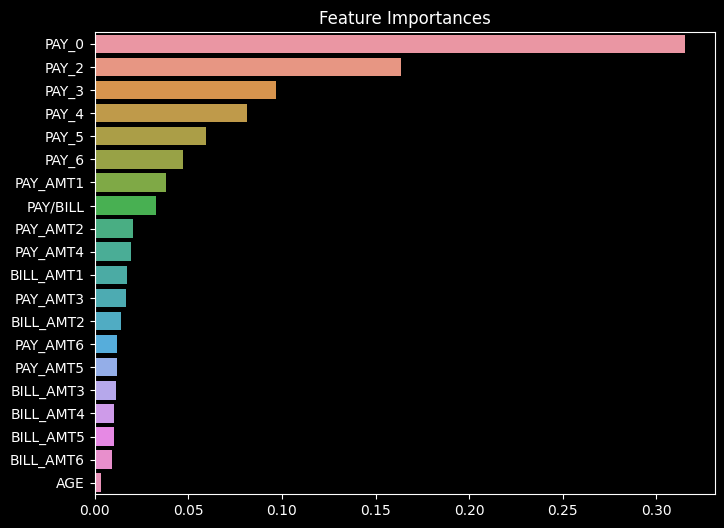

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use(['dark_background'])

#참고로 lightgbm 은 feature_importances()
ftr_importances_values = rfc.feature_importances_                             #각 변수들의 중요도가 array 형태로 출력됨
ftr_importances = pd.Series(ftr_importances_values, index = x_train.columns)    #array 형태이기 때문에 series로 변환
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Feature Importances')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.rc('xtick', labelsize=5)
plt.show()

### · 모델 Save and Read
---
* 최종 모델을 저장 및 다시 불러오기

In [ ]:
import pickle
# 모델 저장
saved_model = pickle.dumps(rfc)

# 모델 Read
clf_from_pickle = pickle.loads(saved_model)


#Y_pred2 = clf_from_pickle.predict(데이터프레임명)
#Y_pred2